In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import gensim.downloader as api
from PIL import Image
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input,GlobalMaxPooling1D,Embedding,TextVectorization,LayerNormalization,MultiHeadAttention)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector

In [ ]:
BATCH_SIZE=64

# Data Preparation

In [ ]:
train_ds,val_ds,test_ds=tfds.load('imdb_reviews', split=['train', 'test[:50%]', 'test[50%:]'],as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteZPQ8TA/imdb_reviews-train.tfrecord*...…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteZPQ8TA/imdb_reviews-test.tfrecord*...:…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteZPQ8TA/imdb_reviews-unsupervised.tfrec…

Dataset imdb_reviews downloaded and prepared to ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
for review,label in val_ds.take(2):
  print(review)
  print(label)

tf.Tensor(b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.", shape=(), dtype=string)
tf.Tensor(1, shape=(),

In [ ]:
def standardization(input_data):
    '''
    Input: raw reviews
    output: standardized reviews
    '''
    lowercase=tf.strings.lower(input_data)
    no_tag=tf.strings.regex_replace(lowercase,"<[^>]+>","")
    output=tf.strings.regex_replace(no_tag,"[%s]"%re.escape(string.punctuation),"")

    return output

In [ ]:
standardization(tf.constant("<u>In the movie?, </u>man called Tévèz, went to a friend’s pl**ce and they had a tensed discussion. I don’t love this movie! would you?<br> <br /><br />T"))

<tf.Tensor: shape=(), dtype=string, numpy=b'in the movie man called t\xc3\xa9v\xc3\xa8z went to a friend\xe2\x80\x99s plce and they had a tensed discussion i don\xe2\x80\x99t love this movie would you t'>

In [ ]:
VOCAB_SIZE=10000
SEQUENCE_LENGTH=250
EMBEDDING_DIM=300

In [ ]:
vectorize_layer=TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH
)

In [ ]:
# lengths=[]
# words=[]

# for review,label in train_ds.take(100):
#   # for word in tf.strings.split(review, sep=" "):
#   #   if word in words:
#   #     pass
#   #   else:
#   #     words.append(word)
#   lengths.append(len(tf.strings.split(review, sep=" ")))

In [ ]:
training_data=train_ds.map(lambda x,y:x)### input x and y and outputx
vectorize_layer.adapt(training_data)#### adapt the vectorize_layer to the training data

In [ ]:
len(vectorize_layer.get_vocabulary())

10000

In [ ]:
def vectorizer(review,label):
    return vectorize_layer(review),label

In [ ]:
train_dataset=train_ds.map(vectorizer)
val_dataset=val_ds.map(vectorizer)

In [ ]:
vectorize_layer.get_vocabulary()[411]

'absolutely'

In [ ]:
for review,label in train_dataset.take(1):
  print(review)
  print(label)

tf.Tensor(
[  10   13   33  411  384   17   89   26    1    8   32 1337 3521   40
  491    1  192   22   84  149   18   10  215  317   26   64  239  212
    8  484   54   64   84  111   95   21 5502   10   91  637  737   10
   17    7   33  393 9554  169 2443  406    2   87 1205  135   65  142
   52    2    1 7408   65  245   64 2832   16    1 2851    1    1 1415
 4969    3   39    1 1567   15 3521   13  156   18    4 1205  881 7874
    8    4   17   12   13 4037    5   98  145 1234   11  236  696   12
   48   22   91   37   10 7285  149   37 1337    1   49  396   11   95
 1148  841  140    9    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [ ]:
train_dataset=train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# Modeling

## Transformers

### Embeddings

In [ ]:
def positional_encoding(model_size,SEQUENCE_LENGTH):
  output=[]
  for pos in range(SEQUENCE_LENGTH):
    PE=np.zeros((model_size))
    for i in range(model_size):
      if i%2==0:
        PE[i]=np.sin(pos/(10000**(i/model_size)))
      else:
        PE[i]=np.cos(pos/(10000**((i-1)/model_size)))
    output.append(tf.expand_dims(PE,axis=0))
  out=tf.concat(output,axis=0)
  out=tf.expand_dims(out,axis=0)
  return tf.cast(out,dtype=tf.float32)

In [ ]:
class Embeddings(Layer):
  def __init__(self, sequence_length, vocab_size, embed_dim,):
    super(Embeddings, self).__init__()
    self.token_embeddings=Embedding(
        input_dim=vocab_size, output_dim=embed_dim)
    self.sequence_length = sequence_length
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim

  def call(self, inputs):
    embedded_tokens = self.token_embeddings(inputs)
    embedded_positions=positional_encoding(
        self.embed_dim,self.sequence_length)
    return embedded_tokens + embedded_positions
    
  def compute_mask(self, inputs, mask=None):
    return tf.math.not_equal(inputs, 0)
    
  def get_config(self): 
      config = super().get_config()
      config.update({
        "sequence_length": self.sequence_length,
        "vocab_size": self.vocab_size,
        "embed_dim": self.embed_dim,
      })
      return config


In [ ]:
test_input=tf.constant([[  2, 112,   10,   12,  5,   0,   0,   0,]])

emb=Embeddings(8,20000,256)
emb_out=emb(test_input)
print(emb_out.shape)

(1, 8, 256)


### Encoder

In [ ]:
class TransformerEncoder(Layer):
    def __init__(self, embed_dim, dense_dim, num_heads,):
        super(TransformerEncoder, self).__init__()
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim,
        )
        self.dense_proj=tf.keras.Sequential(
            [Dense(dense_dim, activation="relu"),Dense(embed_dim),]
        )
        self.layernorm_1 = LayerNormalization()
        self.layernorm_2 = LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
      if mask is not None:
        mask1 = mask[:, :, tf.newaxis]
        mask2 = mask[:,tf.newaxis, :]
        padding_mask = tf.cast(mask1&mask2, dtype="int32")

      attention_output = self.attention(
          query=inputs, key=inputs,value=inputs,attention_mask=padding_mask
      )
      
      proj_input = self.layernorm_1(inputs + attention_output)
      proj_output = self.dense_proj(proj_input)
      return self.layernorm_2(proj_input + proj_output)
      
    def get_config(self): 
      config = super().get_config()
      config.update({
        "embed_dim": self.embed_dim,
        "num_heads": self.num_heads,
        "dense_dim": self.dense_dim,
      })
      return config

In [ ]:
encoder_outputs = TransformerEncoder(256,2048,2)(emb_out)
print(encoder_outputs.shape)


(1, 8, 256)


### Transformer Model

In [ ]:
EMBEDDING_DIM=128
D_FF=1024
NUM_HEADS=8
NUM_LAYERS=1
NUM_EPOCHS=20

In [ ]:
encoder_input=Input(shape=(None,), dtype="int64", name="input")
x = Embeddings(SEQUENCE_LENGTH,VOCAB_SIZE,EMBEDDING_DIM)(encoder_input)

for _ in range(NUM_LAYERS):
  x=TransformerEncoder(EMBEDDING_DIM,D_FF,NUM_HEADS)(x)

x = Flatten()(x) 
output=Dense(1, activation="sigmoid")(x)

transformer = tf.keras.Model(
    encoder_input, output, name="transformer"
)
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None)]            0         
                                                                 
 embeddings_12 (Embeddings)  (None, 250, 128)          1280000   
                                                                 
 transformer_encoder_12 (Tra  (None, 250, 128)         791296    
 nsformerEncoder)                                                
                                                                 
 flatten_4 (Flatten)         (None, 32000)             0         
                                                                 
 dense_33 (Dense)            (None, 1)                 32001     
                                                                 
Total params: 2,103,297
Trainable params: 2,103,297
Non-trainable params: 0
_____________________________________________

## Training

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/transformer.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
transformer.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history=transformer.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint_callback])

Epoch 1/10
391/391 [==============================] - 24s 61ms/step - loss: 0.7082 - accuracy: 0.5192 - val_loss: 0.6960 - val_accuracy: 0.4981
Epoch 3/10
391/391 [==============================] - 24s 61ms/step - loss: 0.6990 - accuracy: 0.5338 - val_loss: 0.6912 - val_accuracy: 0.5258
Epoch 4/10
391/391 [==============================] - 24s 61ms/step - loss: 0.6845 - accuracy: 0.5573 - val_loss: 0.6951 - val_accuracy: 0.4995
Epoch 5/10
391/391 [==============================] - 23s 58ms/step - loss: 0.5823 - accuracy: 0.6841 - val_loss: 0.4385 - val_accuracy: 0.7925
Epoch 6/10
391/391 [==============================] - 22s 57ms/step - loss: 0.3636 - accuracy: 0.8412 - val_loss: 0.4585 - val_accuracy: 0.7892
Epoch 7/10
391/391 [==============================] - 23s 58ms/step - loss: 0.2997 - accuracy: 0.8735 - val_loss: 0.3417 - val_accuracy: 0.8518
Epoch 8/10
391/391 [==============================] - 24s 61ms/step - loss: 0.2556 - accuracy: 0.8945 - val_loss: 0.3554 - val_accuracy:

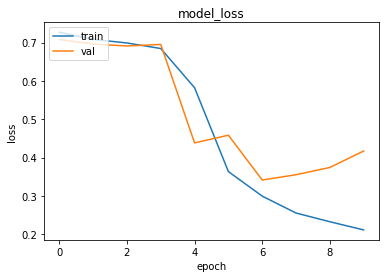

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

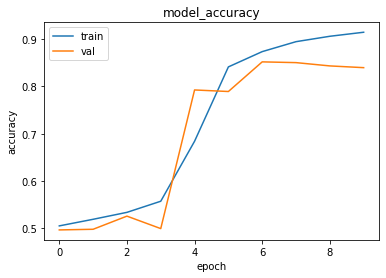

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluation

In [ ]:
transformer.load_weights(checkpoint_filepath)

In [ ]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
transformer.evaluate(test_dataset)

196/196 [==============================] - 5s 23ms/step - loss: 0.3436 - accuracy: 0.8483


[0.3435855805873871, 0.8483200073242188]

# Testing

In [ ]:
# test_pos="this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! "
# test_neg="very good start, but movie started becoming boring at some point and unfortunately i didn't feel like this was properly produced as there was too much background noise, and the actors didn't look motivated at all "

In [ ]:
test_data=tf.data.Dataset.from_tensor_slices([["this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! "],
                                              ["very good start, but movie started becoming uninteresting at some point though initially i thought it would have been much more fun. There was too much background noise, so in all i didn't like this movie "],])


In [ ]:
def vectorizer_test(review):
    return vectorize_layer(review)
test_dataset=test_data.map(vectorizer_test)

In [ ]:
transformer.predict(test_dataset)

array([[0.9175184 ],
       [0.38718796]], dtype=float32)

# LSH Attention

In [ ]:
def look_one_back(x):
  x_extra=tf.concat([x[:,-1:,...],x[:,:-1,...]],axis=1)
  return tf.concat([x,x_extra],axis=2)
  
def sticker_look_one_back(x):
  x_extra=tf.concat([x[:-1:],x[:,:-1]],axis=1)
  return tf.concat([x,x_extra],axis=-1)

def causal_masker(a,b):
  a,b=tf.cast(a,dtype=tf.float32)+0.01,tf.cast(b,dtype=tf.float32)+0.01
  vals=tf.einsum('ipj,ipk->ipjk',b,1/a)
  out=tf.cast(tf.cast(tf.cast(vals,dtype=tf.int32),dtype=tf.bool),dtype=tf.int32)
  out=-out+1
  return tf.cast(out,dtype=tf.float32)

class LSHAttention(tf.keras.layers.Layer):
    def __init__(self,bucket_size=8,n_hashes=1):
        super(LSHAttention,self).__init__()
        self.n_hashes=n_hashes
        self.bucket_size=bucket_size
        
    def call(self,query,key,value,causal_masking=False):
        R=tf.random.normal((tf.shape(query)[0],tf.shape(query)[-1],self.bucket_size//2))
        xR=tf.matmul(query,R)
        concat_xR=tf.concat([xR,-xR],axis=-1)
        buckets=tf.math.argmax(concat_xR,axis=-1)
        
        sticker=tf.argsort(buckets)
        undo_sort=tf.argsort(sticker)
        sorted_query=tf.gather(query,sticker,axis=1,batch_dims=1)
        sorted_value=tf.gather(value,sticker,axis=1,batch_dims=1)
        
        chunked_query=tf.stack(tf.split(sorted_query,self.bucket_size,1),1)
        chunked_value=tf.stack(tf.split(sorted_value,self.bucket_size,1),1)
        
        sticker=tf.stack(tf.split(sticker,self.bucket_size,1),1)
        new_sticker=sticker_look_one_back(sticker)
        
        lb_chunked_query=look_one_back(chunked_query)
        lb_chunked_value=look_one_back(chunked_value)
        
        score=tf.einsum('bhie,bhje->bhij',chunked_query,lb_chunked_query)
        score/=tf.math.sqrt(tf.cast(query.shape[-1],tf.float32))
        
        if causal_masking==True:
            causal_mask=causal_masker(sticker,new_sticker)
            dots+=causal_mask*-1e-10
        score=tf.nn.softmax(score)
        output=tf.einsum('buij,buje->buie',score,lb_chunked_value)
        
        sorted_output=tf.reshape(output,(tf.shape(output)[0],tf.shape(query)[i],output.shape[3]))
        output=tf.gather(sorted_output,undo_sort,axis=1,batch_dims=1)
        return output